<a href="https://colab.research.google.com/github/rudra404/screen-defects-segmentation-UNet/blob/main/UNet_on_TCL_TPDEB_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import os
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

In [112]:
kernel = np.ones((5,5),np.uint8)

In [ ]:
#to turn red (or coloured) labels to white (binary) and remove noise
'''
#walk function to walk through all sub-directories and files in specified root directory
for root, dirs, files in os.walk('drive/MyDrive/Colab Notebooks/TPDEB/png_labels'):
    for file in files:
        if os.path.splitext(file)[1] == '.png': #check if file is .png
            filename = os.path.join(root, file) #save filename as full path
            #print(filename) #checkpoint to show filename
            im = cv2.imread(filename)
            
            # #check image shape and datatype and show the images
            # print(im.shape)
            # print(im.dtype)
            # cv2.namedWindow('image',cv2.WINDOW_NORMAL)
            # cv2.resizeWindow('image', 600,600)
            # cv2.imshow('image', im)
            #for Colab:
            # cv2_imshow(im)
            # cv2.waitKey(0)
            gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            ret,thresh = cv2.threshold(gray,1,255,cv2.THRESH_BINARY)
            opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
            closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
            cv2.imwrite(filename, closing)
'''

In [113]:
temptensor=[]
temptensor1=[]

IMG_HEIGHT = 512
IMG_WIDTH = 512

In [114]:
for root, dirs, files in os.walk('drive/MyDrive/Colab Notebooks/TPDEB/images'):
    dirs.sort()
    for file in sorted(files):
        if os.path.splitext(file)[1] == '.jpg': #check if file is .png
            filename = os.path.join(root, file) #save filename as full path
            #print(filename) #checkpoint to show filename
            im = cv2.imread(filename)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            im = cv2.resize(im, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            im = np.array(im)
            im = im.astype('float')
            im /= 255 
            temptensor.append(im)


In [5]:
print(X[1].shape)
print(X[1].dtype)
print(len(X))


NameError: ignored

In [115]:
X=np.ndarray((170,512,512,1), dtype='float')


In [10]:
print(temp_tensor.dtype)

float64


In [116]:
for i in range(170):
  X[i,:,:,0]=temptensor[i]

In [8]:
X.shape

(170, 512, 512, 1)

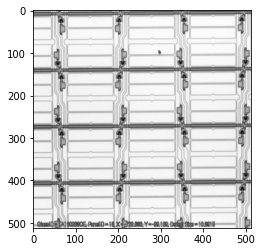

In [10]:

plt.imshow(X[169,:,:,0], cmap='gray')


In [117]:
for root, dirs, files in os.walk('drive/MyDrive/Colab Notebooks/TPDEB/png_labels'):
    dirs.sort()
    for file in sorted(files):
        if os.path.splitext(file)[1] == '.png': #check if file is .png
            filename = os.path.join(root, file) #save filename as full path
            #print(filename) #checkpoint to show filename
            im = cv2.imread(filename)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            im = cv2.resize(im, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            im = np.array(im)
            im = im.astype('float')
            im /= 255 
            temptensor1.append(im)

In [118]:
y=np.ndarray((170,512,512,1), dtype='float')

In [119]:
for i in range(170):
  y[i,:,:,0]=temptensor1[i]

In [12]:
y.shape

(170, 512, 512, 1)

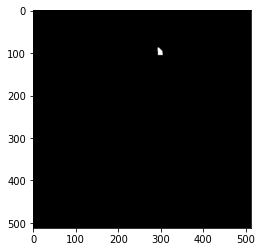

In [16]:
plt.imshow(y[169,:,:,0], cmap='gray')

In [120]:
import sklearn
from sklearn.model_selection import train_test_split

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [19]:
X_train.shape

(119, 512, 512, 1)

(-0.5, 511.5, 511.5, -0.5)

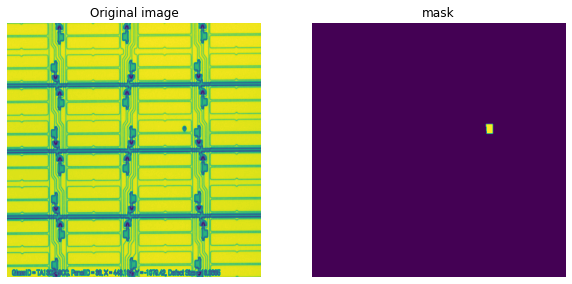

In [103]:
test = np.array(255*(X_test[15,:,:,0]), dtype=np.uint8)
test1 = np.array(255*(y_test[15,:,:,0]), dtype=np.uint8)
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(test)
plt.title('Original image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(test1)
plt.title('mask')
plt.axis('off')

In [122]:
img_rows = 512
img_cols = 512

In [123]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from scipy.ndimage.measurements import label
import time

In [18]:
# # Defining a small Unet
# # Smaller Unet defined so it fits in memory


# def get_small_unet():
#     inputs = Input((img_rows, img_cols, 1))
#     inputs_norm = Lambda(lambda x: x/127.5 - 1.)
#     conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#     conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
#     conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

#     up6 = concatenate([Conv2DTranspose(64, kernel_size=(
#         2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
#     conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
#     conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

#     up7 = concatenate([Conv2DTranspose(32, kernel_size=(
#         2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
#     conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
#     conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

#     up8 = concatenate([Conv2DTranspose(16, kernel_size=(
#         2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
#     conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
#     conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

#     up9 = concatenate([Conv2DTranspose(8, kernel_size=(
#         2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
#     conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
#     conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

#     conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

#     model = Model(inputs=inputs, outputs=conv10)

#     return model

In [124]:
# Defining a small Unet
# Smaller Unet defined so it fits in memory


def get_small_unet():
    inputs = Input((img_rows, img_cols, 1))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(32, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(16, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(8, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [125]:
model = get_small_unet()

In [126]:
def smooth_dice_coeff(smooth=1.):

    smooth = float(smooth)

    # IOU or dice coeff calculation
    def IOU_calc(y_true, y_pred):
            y_true_f = K.flatten(y_true)
            y_pred_f = K.flatten(y_pred)
            intersection = K.sum(y_true_f * y_pred_f)

            return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def IOU_calc_loss(y_true, y_pred):
        return -IOU_calc(y_true, y_pred)
    return IOU_calc, IOU_calc_loss

IOU_calc, IOU_calc_loss = smooth_dice_coeff(0.00001)

In [132]:
model.compile(optimizer=Adam(lr=1e-4), loss=IOU_calc_loss, metrics=[IOU_calc])

In [133]:
 history = model.fit(X_train, y_train, batch_size=10, epochs=18, verbose=1, validation_split=0.1)

Epoch 1/18
11/11 [==============================] - 8s 575ms/step - loss: -0.0036 - IOU_calc: 0.0035 - val_loss: -0.0054 - val_IOU_calc: 0.0041
Epoch 2/18
11/11 [==============================] - 6s 551ms/step - loss: -0.0028 - IOU_calc: 0.0028 - val_loss: -0.0054 - val_IOU_calc: 0.0041
Epoch 3/18
11/11 [==============================] - 6s 555ms/step - loss: -0.0037 - IOU_calc: 0.0037 - val_loss: -0.0054 - val_IOU_calc: 0.0041
Epoch 4/18
11/11 [==============================] - 6s 556ms/step - loss: -0.0033 - IOU_calc: 0.0033 - val_loss: -0.0054 - val_IOU_calc: 0.0041
Epoch 5/18
11/11 [==============================] - 6s 560ms/step - loss: -0.0035 - IOU_calc: 0.0035 - val_loss: -0.0054 - val_IOU_calc: 0.0041
Epoch 6/18
11/11 [==============================] - 6s 560ms/step - loss: -0.0035 - IOU_calc: 0.0035 - val_loss: -0.0054 - val_IOU_calc: 0.0041
Epoch 7/18
11/11 [==============================] - 6s 562ms/step - loss: -0.0038 - IOU_calc: 0.0038 - val_loss: -0.0054 - val_IOU_calc:

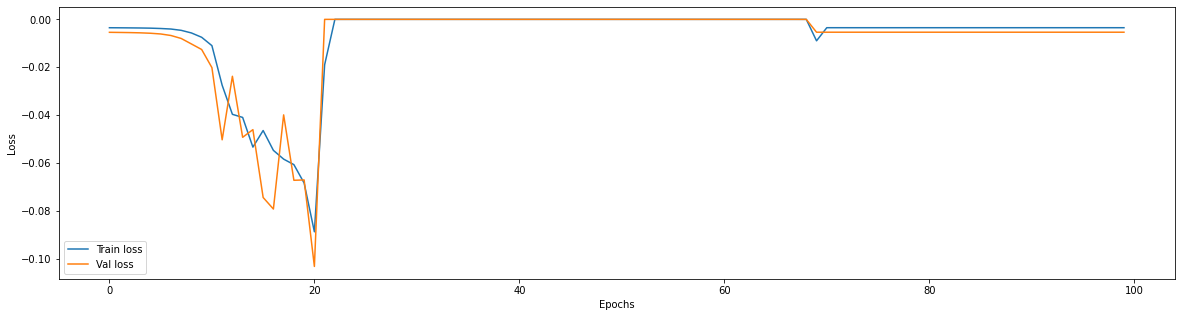

In [129]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Train loss')
plt.plot(model.history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

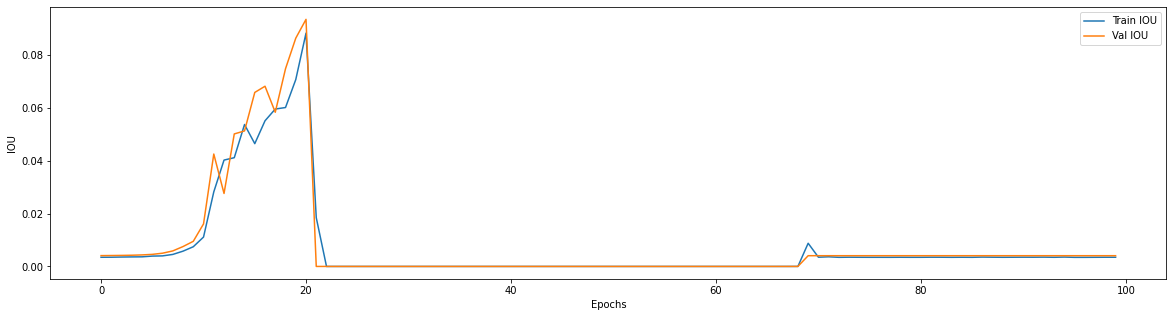

In [130]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['IOU_calc'], label='Train IOU')
plt.plot(model.history.history['val_IOU_calc'], label='Val IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()

In [131]:
predict = model.predict(X_test)

In [85]:
import numpy as np
import cv2


def predict_evaluation(pred, image, label):
    '''
    '''
    # transform gray image to rgb
    img = np.array(255*image, dtype=np.uint8)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # scale pred and mask's pixel range to 0~255
    im_label = np.array(255*label, dtype=np.uint8)
    im_pred = np.array(255*pred, dtype=np.uint8)

    # transform both of them to rgb
    rgb_label = cv2.cvtColor(im_label, cv2.COLOR_GRAY2RGB)
    rgb_pred = cv2.cvtColor(im_pred, cv2.COLOR_GRAY2RGB)

    rgb_label[:, :, 1:3] = 0*rgb_label[:, :, 1:3]
    rgb_pred[:, :, 0] = 0*rgb_pred[:, :, 0]
    rgb_pred[:, :, 2] = 0*rgb_pred[:, :, 2]

    img_pred = cv2.addWeighted(rgb_img, 1, rgb_pred, 0.8, 0)
    img_label = cv2.addWeighted(rgb_img, 1, rgb_label, 0.8, 0)

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_img)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img_pred)
    plt.title('Prediction')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(img_label)
    plt.title('Ground truth')
    plt.axis('off')

In [88]:
imgnum=0

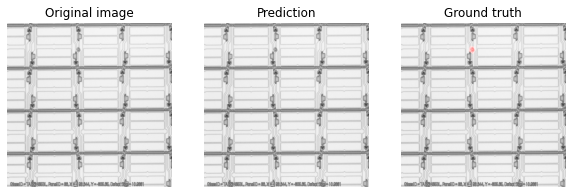

In [89]:
predict_evaluation(predict[imgnum,:,:,0], X_test[imgnum,:,:,0], y_test[imgnum,:,:,0])

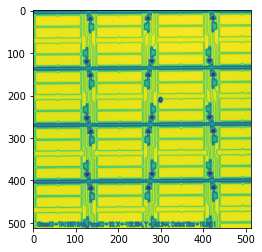

In [36]:
plt.imshow(X_test[28,:,:,0])